# ***Imports***

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import io
import os
import random
import cv2
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, Resizing, Dropout,MaxPool2D,InputLayer,Flatten,BatchNormalization,Conv2D,Dense
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

# ***Data Management***

## ***Data Downloading***

In [2]:
!pip install -q kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 307M/309M [00:08<00:00, 20.6MB/s]
100% 309M/309M [00:08<00:00, 40.1MB/s]


In [6]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [7]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry","happy","sad"]

In [8]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

## ***Dataset Loading***

In [9]:
train_dataset = image_dataset_from_directory(
    train_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION["CLASS_NAMES"],
    color_mode = 'rgb',
    batch_size = CONFIGURATION["BATCH_SIZE"],
    image_size = (CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99,
)

Found 6799 files belonging to 3 classes.


In [10]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [11]:
val_dataset = image_dataset_from_directory(
    val_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION["CLASS_NAMES"],
    color_mode = 'rgb',
    batch_size = 1,
    image_size =(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99
)

Found 2278 files belonging to 3 classes.


In [12]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 89.      ,  89.      ,  89.      ],
         [ 91.4375  ,  91.4375  ,  91.4375  ],
         [ 85.8125  ,  85.8125  ,  85.8125  ],
         ...,
         [ 26.6875  ,  26.6875  ,  26.6875  ],
         [ 26.      ,  26.      ,  26.      ],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 79.25    ,  79.25    ,  79.25    ],
         [ 86.30859 ,  86.30859 ,  86.30859 ],
         [ 87.89453 ,  87.89453 ,  87.89453 ],
         ...,
         [ 25.875   ,  25.875   ,  25.875   ],
         [ 25.339844,  25.339844,  25.339844],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 71.5     ,  71.5     ,  71.5     ],
         [ 79.625   ,  79.625   ,  79.625   ],
         [ 87.60156 ,  87.60156 ,  87.60156 ],
         ...,
         [ 24.570312,  24.570312,  24.570312],
         [ 23.253906,  23.253906,  23.253906],
         [ 24.625   ,  24.625   ,  24.625   ]],

        ...,

        [[170.      , 170.      ,

## ***Dataset Visualization***

In [13]:
def show_image(dataset):
  plt.figure(figsize = (12,12))
  for images,labels in dataset.take(1):
    for i in range(16):
      ax = plt.subplot(4,4,i+1)
      plt.imshow(images[i]/255.)
      plt.title(CLASS_NAMES[tf.argmax(labels[i],axis = 0).numpy()])
      plt.axis("off")

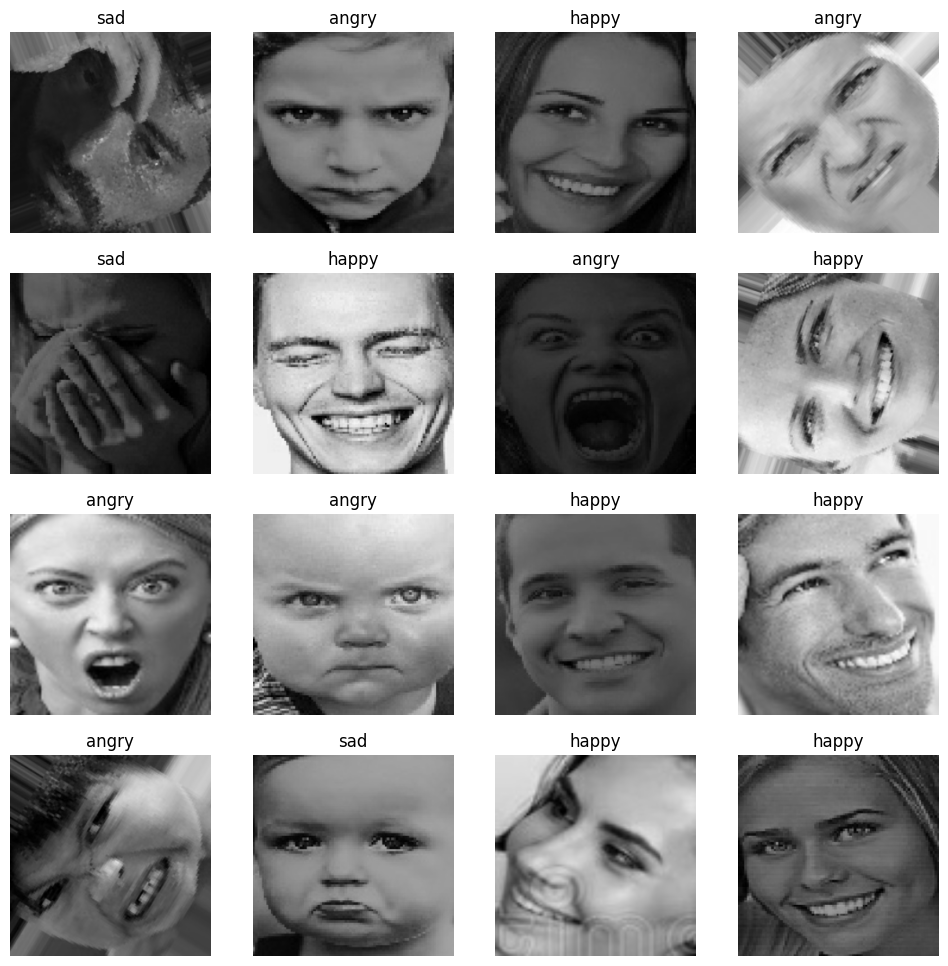

In [14]:
show_image(train_dataset)

## ***Resize_Rescale***

In [15]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255)
])

## ***Data Augmentation***

In [16]:
augment_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor = (-0.025,0.025)),
    tf.keras.layers.RandomFlip(mode = 'horizontal'),
    tf.keras.layers.RandomContrast(factor = 0.1)
])

In [17]:
def augment_layer(image,label):
  return augment_layers(image, training=True), label

## ***Dataset Preperation***

In [18]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [19]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [20]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [21]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

## **Plot Visualization**

In [22]:
def model_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['loss','val_loss'])
  plt.show()

In [23]:
def model_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['accuracy','val_accuracy'])
  plt.show()

# ***Callbacks***

## ***Early Stopping***

In [24]:
es_callback = EarlyStopping(
    monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 1,
    mode = 'auto', baseline = None, restore_best_weights = False
)

## ***Model Checkpoint***

In [26]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True,
)

# ***Model***

In [27]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (None,None,3)),
    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"],kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION["N_STRIDES"],padding = "valid",
           activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION["POOL_SIZE"], strides = CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),


    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 +4,kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION["N_STRIDES"],padding = "valid",
           activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION["POOL_SIZE"], strides = CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense(CONFIGURATION["N_DENSE_2"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),


])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

## ***Training***

In [29]:
loss_function = CategoricalCrossentropy()

In [30]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k =2,name = "top_k_accuracy")]

In [31]:
model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [32]:
history = model.fit(training_dataset,validation_data=validation_dataset,epochs =CONFIGURATION["N_EPOCHS"], verbose = 1, callbacks = [checkpoint_callback])

Epoch 1/20
213/213 [==============================] - ETA: 0s - loss: 0.9993 - accuracy: 0.5430 - top_k_accuracy: 0.8123
Epoch 1: val_accuracy improved from -inf to 0.53775, saving model to best_weights
213/213 [==============================] - 75s 288ms/step - loss: 0.9993 - accuracy: 0.5430 - top_k_accuracy: 0.8123 - val_loss: 1.0096 - val_accuracy: 0.5378 - val_top_k_accuracy: 0.7757
Epoch 2/20
212/213 [============================>.] - ETA: 0s - loss: 0.8186 - accuracy: 0.6303 - top_k_accuracy: 0.8676
Epoch 2: val_accuracy improved from 0.53775 to 0.58297, saving model to best_weights
213/213 [==============================] - 67s 308ms/step - loss: 0.8182 - accuracy: 0.6307 - top_k_accuracy: 0.8678 - val_loss: 0.9462 - val_accuracy: 0.5830 - val_top_k_accuracy: 0.8108
Epoch 3/20
212/213 [============================>.] - ETA: 0s - loss: 0.7405 - accuracy: 0.6742 - top_k_accuracy: 0.8899
Epoch 3: val_accuracy improved from 0.58297 to 0.65584, saving model to best_weights
213/213 [

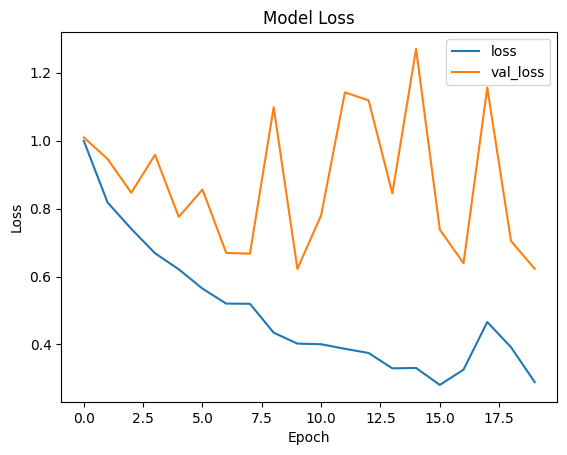

In [33]:
model_loss(history)

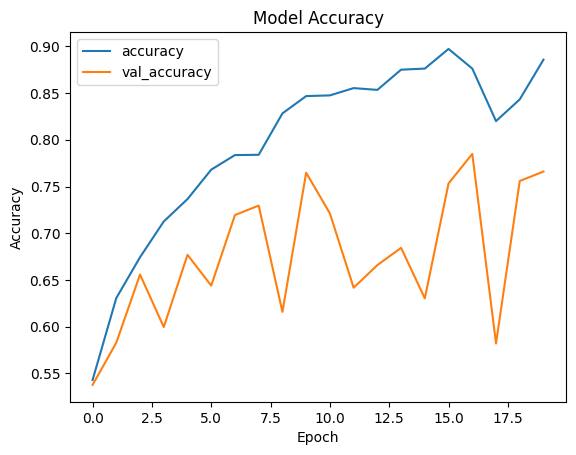

In [34]:
model_accuracy(history)

## ***Evaluation***

In [35]:
model.load_weights('best_weights')

In [36]:
model.evaluate(validation_dataset)

2278/2278 [==============================] - 11s 5ms/step - loss: 0.6391 - accuracy: 0.7849 - top_k_accuracy: 0.9359


[0.6390620470046997, 0.7848990559577942, 0.9359086751937866]

## ***Testing***

In [37]:
test_image = cv2.imread('/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg')
im = tf.constant(test_image,dtype = tf.float32)
print(im.shape)

(224, 224, 3)


In [38]:
im = tf.expand_dims(im,axis = 0)
im.shape

TensorShape([1, 224, 224, 3])

In [39]:
model(im)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9911209 , 0.00760184, 0.00127731]], dtype=float32)>

In [40]:
print(CLASS_NAMES[tf.argmax(model(im),axis = -1).numpy()[0]])

angry


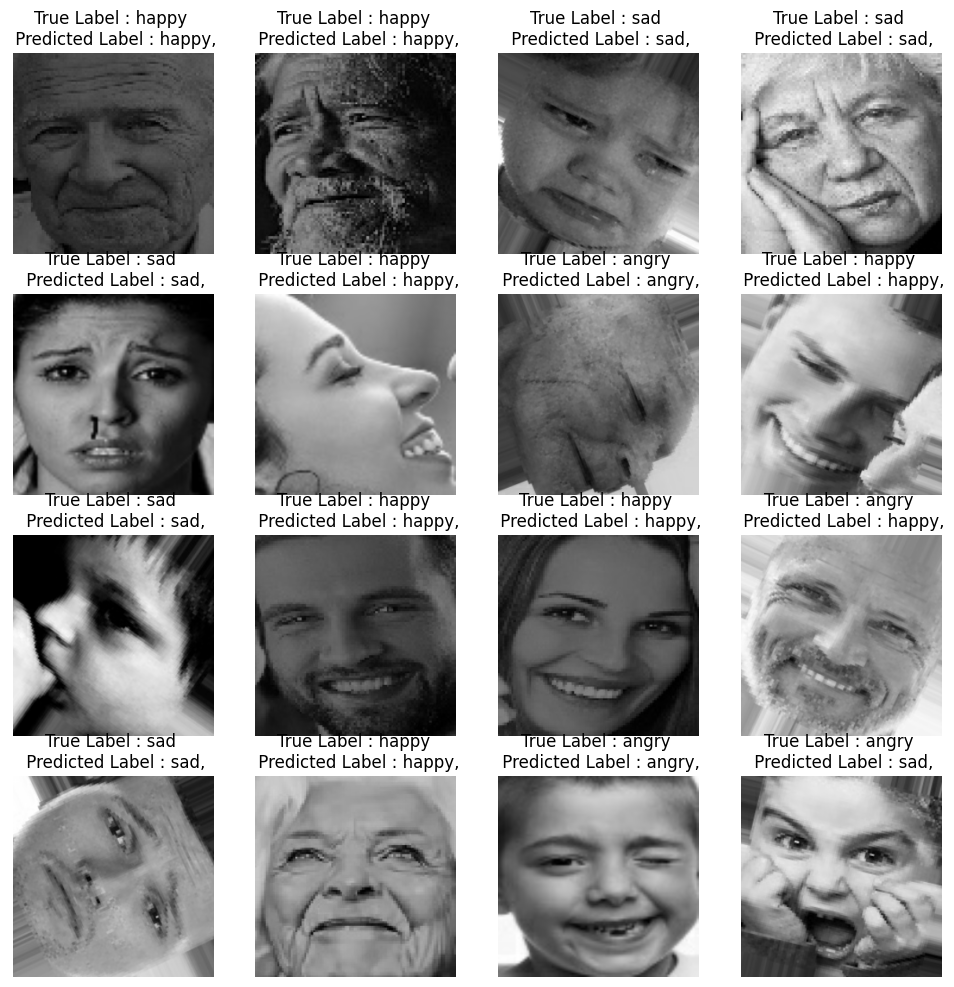

In [41]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(f'True Label : {CLASS_NAMES[tf.argmax(labels[i],axis = 0).numpy()]} \n Predicted Label : {CLASS_NAMES[tf.argmax(model(tf.expand_dims(images[i],axis = 0)),axis = -1).numpy()[0]]},')
    plt.axis('off')

## ***Confusion Matrix***

In [42]:
predicted = []
labels = []

for im,label in validation_dataset:
  predicted.append(model(im))
  labels.append(label)

In [43]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 2 ... 2 0 1]
[1 1 2 ... 2 1 2]


In [44]:
pred = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

[[336  42  67]
 [ 87 895 133]
 [ 92  69 557]]


Text(0.5, 58.7222222222222, 'Predicted')

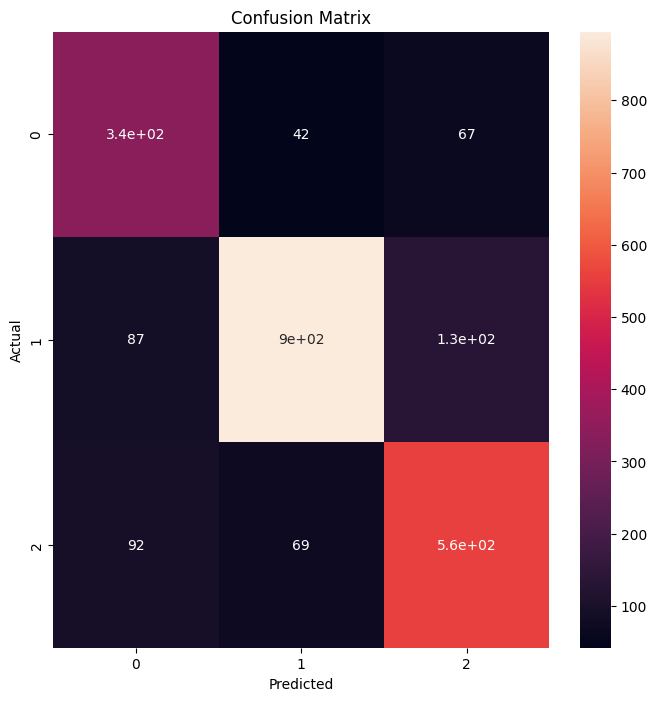

In [45]:
cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize=(8,8))
sns.heatmap(cm,annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
